In [2]:
# import Pkg
# Pkg.add("Plots")
# Pkg.add("Distributions")
# Pkg.add("StatsBase")
# Pkg.add("DataFrames")
# Pkg.add("ProgressMeter")
# Pkg.add("CSV")
push!(LOAD_PATH, "C:/Users/lisag/Downloads/Workspace BA")
using DendriticBranches: is_subset, is_contiguous_subset, find_first_target_symbols


In [3]:
using StatsBase, Distributions, Plots, DataFrames,ProgressMeter,CSV, ROCAnalysis

const trial = Vector{Tuple{Vector{Symbol}, Vector{Float64}, Bool}} 
const contingency = Vector{Tuple{Float64,Int64, Int64,Int64, Int64}}

Vector{Tuple{Float64, Vararg{Int64, 4}}} (alias for Array{Tuple{Float64, Vararg{Int64, 4}}, 1})

In [4]:
struct Misclassified
    trials::Tuple{Vector{Symbol}, Vector{Float64}, Bool}
    target::Vector{Any}
end

In [5]:
alphabet = [:A, :B , :C]
distractor = :D
target = [:A, :B , :C]
trials_count = 50

50

In [6]:
# Distributions

function gaussian(; args::NamedTuple)
    # negative values are truncated
    value = rand(Normal(args.mean, args.sd))
    return value > 0 ? value : gaussian(args=(mean=args.mean, sd=args.sd))
end

# jitters between 20 and 80 
function uniform(; args::NamedTuple )
    return rand(Uniform(args.bound_start,args.bound_end))
end

function gamma(; args::NamedTuple )
    #theta = args.alpha / args.mean
    theta = args.mean / args.alpha 
    return rand(Gamma(args.alpha,theta))
end

gamma (generic function with 1 method)

In [7]:
# In order to check for edge cases : save Misclassified trials 
function save_misclassified(trials, target)
    experiment_data = Misclassified(trials, target)
    # in Filename condition of experiemnt hinzufügen? 
    filename = "Misclassified Trials/Misclassified_trials.jl"

    if countlines(filename) < 100 
        open(filename, "a") do io
            println(io, "Experiment_data = ", experiment_data)
        end
    end 

end 

save_misclassified (generic function with 1 method)

In [8]:
function save_performances(performances, experiment_condition)
    filename = "Performances/Performances.jl"

    if countlines(filename) < 100 
        open(filename, "a") do io
            println(io, "$experiment_condition = ", performances)
        end
    end 
end 

save_performances (generic function with 1 method)

In [29]:
function check_extra_condition(seq::Vector{Symbol}, subseq::Vector{Symbol})
    indices = find_first_target_symbols(seq, subseq)
    return isnothing(indices) ? false : all(abs(indices[i] - indices[i-1]) >= 2 for i in 2:length(indices))
end

check_extra_condition (generic function with 1 method)

In [30]:
function gen_seuqence(alphabet::Vector{Symbol} , length::Int64)
    return StatsBase.sample(alphabet,length)
end


# add parameter mean? 
function generate_timings(sequence_length::Int64,timing_distribution::Function, distribution_args::NamedTuple)
    timings = Float64[]
    for index in 1:sequence_length
        if index == 1
            push!(timings, 0.0 + (timing_distribution(args=distribution_args)))
        else 
            push!(timings, timings[index - 1] + (timing_distribution(args=distribution_args)))

        end
    end
    return timings
end


function generate_trails(alphabet::Vector{Symbol}, 
                         sequence_length::Int64, 
                         target::Vector{T} where T<:Union{Symbol, Any},
                         timing_distribution::Function,
                         distribution_args::NamedTuple
                         ; trail_count::Int64 = 50 , balanced = true, extra_condition= false)
    trials = Tuple{Vector{Symbol},Vector{Float64}, Bool}[]
    
    if !balanced
        while length(trials) != trail_count
            sequence = gen_seuqence(alphabet,sequence_length)
            timings = generate_timings(sequence_length,timing_distribution,distribution_args)
            if is_subset(target, sequence) #&& is_contiguous_subset(target,sequence) #remove second condition
                push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
            end
        end
    else
        while length(trials) != floor(trail_count/2)
            sequence = gen_seuqence(alphabet,sequence_length)
            timings = generate_timings(sequence_length,timing_distribution,distribution_args)
            if is_subset(target, sequence) && is_contiguous_subset(target,sequence) 
                push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
            end
        end

        # in false trials the target needs to be in the sequence however with distractors in between
        if extra_condition 
            while length(trials) != trail_count
                sequence = gen_seuqence(alphabet,sequence_length)
                timings = generate_timings(sequence_length,timing_distribution,distribution_args)
                if is_subset(target, sequence) && !is_contiguous_subset(target,sequence) && check_extra_condition(sequence, target) 
                    push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
                end
            end

        else 
            while length(trials) != trail_count
                sequence = gen_seuqence(alphabet,sequence_length)
                timings = generate_timings(sequence_length,timing_distribution,distribution_args)
                if is_subset(target, sequence) && !is_contiguous_subset(target,sequence) 
                    push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
                end
            end
        end 
    end

    return trials
end


function find_all_target_indices(seq::Vector{Symbol} , subseq::Vector{Symbol})
    indices = Int64[]
    len_subseq = length(subseq)
    len_seq = length(seq)
    for i in 1:(len_seq - len_subseq + 1)
        if seq[i:i+len_subseq-1] == subseq
            push!(indices,i)
        end
    end
    return indices
end

find_all_target_indices (generic function with 1 method)

In [11]:
function contingency_table(trials::trial, predictions::Vector{Bool}, tau::Float64)
    fp = 0
    fn = 0 
    tp = 0
    tn = 0
    for index in 1:length(trials)
        if trials[index][3] == true && predictions[index] == false
            fn += 1
        elseif trials[index][3] == false && predictions[index] == true
            fp += 1
        elseif trials[index][3] == false && predictions[index] == false
            tn += 1
        elseif trials[index][3] == true && predictions[index] == true
            tp += 1
        
        end
    end
    return (tau,fp,fn,tp,tn)
end

contingency_table (generic function with 1 method)

In [12]:
function naive_dendritic_classifier(trials::trial , target::Vector{Symbol}, tau::Float64)
    detected = Bool[]
    for trial in trials
        #println("TRIAL ", trial)
        target_location = find_first_target_symbols(trial[1],target)
        if target_location != nothing
            detect = true
            for i in 1:(length(target_location) - 1)
                #println("tau >= ", trial[2][target_location[i+1]], " - ", trial[2][target_location[i]], " : Result is  ",  tau >= (trial[2][target_location[i+1]] - trial[2][target_location[i]]))
                detect &= ( tau >= (trial[2][target_location[i+1]] - trial[2][target_location[i]]))
            end
            push!(detected,detect)
            # save misclassified trials ! zu ressourcenintensiv (zu viele Beispiele)
            # if detect != trial[3]
            #     save_misclassified(trial, target)
            # end 

        else 
            push!(detected,false)
        end
    end
    
    return detected, contingency_table(trials, detected ,tau)
    #return contingency_table(trials, detected ,tau)
end

naive_dendritic_classifier (generic function with 1 method)

In [13]:
function naive_dendritic_classifier(trials::trial , target::Vector{Any}, tau::Float64)
    # printen(target location wird zu einer liste mit mehreren? habe gesehen dass in der liste nothing sein kann?! fixen )
    detected = Bool[]
    for trial in trials
        #println("TRIAL IS ", trial)
        target_locations = find_first_target_symbols(trial[1], target)
        #println("TARGET LOCATION ", target_locations)
        if any(x -> test_target_location(x, trial, detected, tau), target_locations)
            #println("CLASSIFIED AS ", true)
            push!(detected, true)
        else 
            #println("CLASSIFIED AS ", false)
            push!(detected, false )
        end 
    end
    
    return detected, contingency_table(trials, detected ,tau)
end

naive_dendritic_classifier (generic function with 2 methods)

In [14]:
function test_target_location(target_location, trial, detected, tau)
    if target_location != nothing
        detect = true
        for i in 1:(length(target_location) - 1)
            detect &= ( tau >= (trial[2][target_location[i+1]] - trial[2][target_location[i]]))
        end
        return detect 
    else 
        return false 
    end
end 

test_target_location (generic function with 1 method)

In [15]:
# performance tuple structure : (tau,fp,fn,tp,tn)

function accuracy(performance::contingency, trialcount::Int64)
    accuracy = Float64[]
    tau = Float64[]
    for table in performance
        acc = ((table[4] + table[5]) / trialcount ) * 100.0
        push!(accuracy, acc )
        push!(tau, table[1])
    end
    return tau, accuracy
end

function f_score(performance::contingency)
    score = Float64[]
    tau = Float64[]
    for table in performance
        fscore = ((table[4]) / (table[4] + ((table[2] + table[3]) * 0.5)) ) * 100.0
        push!(score, fscore )
        push!(tau, table[1])
    end
    return tau, score
end

function sensitivity(performance::contingency)
    sensitivities = Float64[]
    tau = Float64[]
    for table in performance
        sens = ((table[4]) / (table[4] + table[3]) ) * 100.0
        push!(sensitivities, sens )
        push!(tau, table[1])
    end
    return tau, sensitivities
end

function specificity(performance::contingency)
    specificities = Float64[]
    tau = Float64[]
    for table in performance
        spec = ((table[5]) / (table[5] + table[2]) ) * 100.0
        push!(specificities, spec )
        push!(tau, table[1])
    end
    return tau, specificities
end

function roc(performance::contingency)
    TP_rate = Float64[]
    FP_rate = Float64[]
    for table in performance
        push!(TP_rate, (table[4] / (table[4] + table[3])) * 100 )
        push!(FP_rate, (table[2] / (table[2] + table[5])) * 100)
    end
    return FP_rate,TP_rate
end

roc (generic function with 1 method)

In [16]:
function experiment(dist::Function,
                    distribution_args::NamedTuple;
                    setup::NamedTuple
                    )
    
    trials = generate_trails(setup.alphabet,
                             setup.sequence_length,
                             setup.target,
                             dist,
                             distribution_args, 
                             trail_count = setup.trial_per_experiment,
                             balanced = setup.balanced)
    predictions = Tuple{Float64,Vector{Bool}}[]
    performance = Tuple{Float64,Int64, Int64,Int64, Int64}[]
    for tau in setup.min_tau:setup.step:setup.max_tau
        predict , table = naive_dendritic_classifier(trials,setup.target,tau)
        push!(performance, table)
        push!(predictions, (tau , predict))
    end
    return predictions,performance
end

experiment (generic function with 1 method)

In [17]:
function draw(performances,distribution;setup::NamedTuple)
    timing_mean = performances[3]
    performance = performances[2]
    distargs = performances[1]
    tau , score = f_score(performance)
    _ , sensitivities = sensitivity(performance)
    _ , specificities = specificity(performance)
    _ , acc = accuracy(performance,setup.trial_per_experiment)
    #plot_title = "performance measures on timings from\n $dist_name distribution with $distribution_arguments"
    plot_title = "performance measures for $(setup.trial_per_experiment) sequence trials \n of the length $(setup.sequence_length). Trials were balanced: $(setup.balanced)\n timing jitters from $distribution with: $distargs + $timing_mean \n"
    plot(tau , score; title= plot_title, label = "f1 score curve",lw=3,titlefontsize=7)
    plot!(tau , acc; title= plot_title, label = "accuracy curve",lw=3,titlefontsize=7)
    plot!(tau , sensitivities; title= plot_title, label = "sensitivities curve",lw=2, linestyle=:dash,titlefontsize=7)
    plot!(tau , specificities; title= plot_title, label = "specificity curve",lw=2,linestyle=:dash,titlefontsize=7)
    plot!(ylims = (0,100))
    plot!(xlabelfontsize=8)
    plot!(ylabelfontsize=8)
    plot!(legend=:outerbottom ,legendfontsize=7)
    
    # was genau bedeutet y5? 
    if distribution == "uniform" 
        plot!([(distargs.bound_start + (1.5*distargs.bound_end))], seriestype="vline")
    elseif distribution == "gaussian"
        plot!([(distargs.mean + (1.5*distargs.sd))], seriestype="vline")
    elseif distribution == "gamma"
        # will man hier alpha oder theta haben?
        # was genau wird eigentlich geplottet?
        # warum 1.5*distargs? 
        plot!([(distargs.mean + (1.5*distargs.alpha))], seriestype="vline")
    end 

    ylabel!("performance %")
    xlabel!("Plateau length \n")
end

draw (generic function with 1 method)

In [18]:
function draw_roc(performances,distribution;setup::NamedTuple)
    performance = performances[2]
    distargs = performances[1]
    timing_mean = performances[3]
    tau, _ = f_score(performance)
    FP_rate , TP_rate = roc(performance)
    AUC_score = auc(FP_rate, TP_rate)
    plot_title = "ROC measures for $(setup.trial_per_experiment) sequence trials \n of the length $(setup.sequence_length). Trials were balanced: $(setup.balanced)\n from $distribution with: $distargs + $timing_mean \n AUC: $AUC_score"
    plot(FP_rate , TP_rate; title= plot_title, label = "ROC curve for plateau length",lw=3,titlefontsize=7)
    plot!(ylims = (0,100))
    plot!(xlims = (0,100))
    plot!(xlabelfontsize=7)
    plot!(ylabelfontsize=7)
    plot!(legend=:outerbottom ,legendfontsize=7)
    ylabel!("True Positive Rate %")
    xlabel!("False Positive Rate % \n")
end

draw_roc (generic function with 1 method)

In [20]:
# DENDRITIC STRUCTURES DISCUSSED WITH FARBOD FOR THESIS 

# TYPE E 
target_E1 = [:A, :B, :C]
target_E2 = [:A, :A, :A]
target_E3 = [:A, :B, :B, :A, :C, :B]
target_E4 = [:B, :C]

# TYPE D 
target_D1 = [ [:||, :A, :B], :C ]
target_D2 = [ [:&, :A, :B], :C ]
target_D3 = [ [:&, :A, :B, :C, :F], :D ]
target_D4 = [ [:||, :A, :B, :C, :F], :D ]

# TYPE F 
target_F1 = [ [:&, [ [:||, :A, :B], :C], :D], :E] 
target_F2 = [ [:||, [ [:&, :A, :B], :C], :D], :E] 
target_F3 = [ [:&, [ [:&, :A, :B], :C], :D], :E] 
target_F4 = [ [:||, [ [:||, :A, :B], :C], :D], :E] 

# TYPE G
target_G1 = [ [:&, [[:||, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 
target_G2 = [ [:&, [[:&, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 
target_G3 = [ [:||, [[:||, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 
target_G4 = [ [:||, [[:||, :A, :B], :E], [[:||, :D, :C], :F] ], :G ] 
target_G5 = [ [:&, [[:||, :A, :B], :E], [[:||, :D, :C], :F] ], :G ] 
target_G6 = [ [:||, [[:&, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 

2-element Vector{Any}:
 Any[:||, Any[[:&, :A, :B], :E], Any[[:&, :D, :C], :F]]
 :G

In [19]:
function plot_progress(iteration, total)
    progress = round(iteration / total * 100)
    bar_length = 50
    num_bars = round(Int, progress / (100 / bar_length))
    remaining_bars = bar_length - num_bars
    bar = "[" * repeat("=" , num_bars) * repeat(" ", remaining_bars) * "]"
    print("\rProgress: $bar ($progress%)")
end

plot_progress (generic function with 1 method)

In [20]:
# EXPERIMENT VANILLA GAUSSIAN 
experiment_setup = (alphabet = [:A, :B, :C],
         target = target_E1,
         sequence_length=10,
         trial_per_experiment = 600,
         min_tau = 20.0,
         max_tau=600.0,
         step=1.0,
         balanced=true
         )
performances = Tuple[]
distname = gaussian

# LOOP THROUGH MEAN 100-400?
for timing_mean in 1:1:400

    # plot progress 
    plot_progress(timing_mean, 400)
    
    if distname == gaussian
        distargs = (mean = 80, sd = 10)
    elseif distname == uniform
        distargs = (bound_start = 0, bound_end = sigma)
    elseif distname == gamma
        distargs = (mean = 80, alpha = 1)
    end 
    
    _ , performance = experiment(distname,distargs;setup=experiment_setup)
    push!(performances,(distargs, performance, timing_mean))
end

Progress: [==================================================] (100.0%)

In [21]:
save_performances(performances, "target_D1_Balanced_gaussian_with_JITTER")

┌ Info: Saved animation to c:\Users\lisag\Downloads\Workspace BA\performance target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif
└ @ Plots C:\Users\lisag\.julia\packages\Plots\7R93Y\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\lisag\\Downloads\\Workspace BA\\performance target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif")
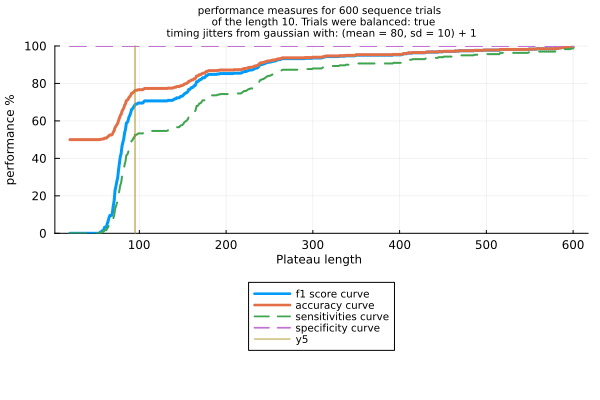

In [26]:
anim = @animate for i in 1:length(performances)
    draw(performances[i],string(distname);setup=experiment_setup)
end
gif(anim, "performance target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif", fps = 15)

┌ Info: Saved animation to c:\Users\lisag\Downloads\Workspace BA\ROC target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif
└ @ Plots C:\Users\lisag\.julia\packages\Plots\7R93Y\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\lisag\\Downloads\\Workspace BA\\ROC target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif")
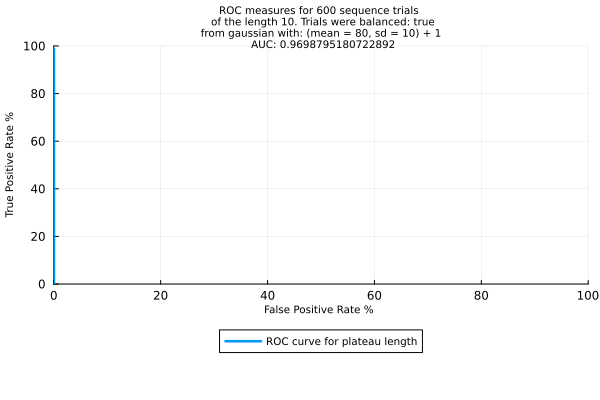

In [31]:
anim = @animate for i in 1:length(performances)
    draw_roc(performances[i],string(distname);setup=experiment_setup)
end
gif(anim, "ROC target_D1_Balanced_gaussian_with_JITTER timing mean in range 1 to 400 step of 1.gif", fps = 15)

In [109]:
# was hat Farbod hier gemacht?

plot1 = draw(performances[1],string(distname);setup=experiment_setup)
plot2 = draw(performances[50],string(distname);setup=experiment_setup)
plot3 = draw(performances[100],string(distname);setup=experiment_setup)
plot4 = draw(performances[200],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3, plot4,  layout=(2, 2), size=(1000, 1000))
savefig(combined_plot,"performance four pannel normal gima in range 1 to 200 step of 1.png")


"c:\\Users\\lisag\\Downloads\\Workspace BA\\performance four pannel normal gima in range 1 to 200 step of 1.png"

In [28]:
# step wise from 1 to 400 timing_mean 

plot1 = draw(performances[1],string(distname);setup=experiment_setup)
plot2 = draw(performances[50],string(distname);setup=experiment_setup)
plot3 = draw(performances[100],string(distname);setup=experiment_setup)
plot4 = draw(performances[200],string(distname);setup=experiment_setup)
plot5 = draw(performances[300],string(distname);setup=experiment_setup)
plot6 = draw(performances[400],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3, plot4, plot5, plot6,  layout=(2, 3), size=(1500, 1000))
savefig(combined_plot,"performance target_D1_Balanced_gaussian_with_JITTER Timing mean form 1 to 400 step of 1.png")


"c:\\Users\\lisag\\Downloads\\Workspace BA\\performance target_D1_Balanced_gaussian_with_JITTER Timing mean form 1 to 400 step of 1.png"

In [32]:
plot1 = draw_roc(performances[2],string(distname);setup=experiment_setup)
plot2 = draw_roc(performances[50],string(distname);setup=experiment_setup)
plot3 = draw_roc(performances[100],string(distname);setup=experiment_setup)
plot4 = draw_roc(performances[200],string(distname);setup=experiment_setup)
plot5 = draw_roc(performances[300],string(distname);setup=experiment_setup)
plot6 = draw_roc(performances[400],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3, plot4,plot5, plot6, layout=(2, 3), size=(1000, 1000))
savefig(combined_plot,"ROC curve target_D1_Balanced_gaussian_with_JITTERTiming mean form 1 to 400 step of 1.png")

"c:\\Users\\lisag\\Downloads\\Workspace BA\\ROC curve target_D1_Balanced_gaussian_with_JITTERTiming mean form 1 to 400 step of 1.png"

In [2]:
plot1 = draw_roc(performances[50],string(distname);setup=experiment_setup)
plot2 = draw_roc(performances[100],string(distname);setup=experiment_setup)
plot3 = draw_roc(performances[150],string(distname);setup=experiment_setup)
plot4 = draw_roc(performances[200],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3, plot4, layout=(2, 2), size=(1000, 1000))

UndefVarError: UndefVarError: `performances` not defined

In [51]:
# was ist das hier? 

"""labels = Bool[]
for trial in trials
    push!(labels,trial[3])
end
df = DataFrame(label = labels)
for prediction in predictions
    df[!,string(prediction[1])] = prediction[2]
end
CSV.write("predictions.csv",df)"""

"labels = Bool[]\nfor trial in trials\n    push!(labels,trial[3])\nend\ndf = DataFrame(label = labels)\nfor prediction in predictions\n    df[!,string(prediction[1])] = prediction[2]\nend\nCSV.write(\"predictions.csv\",df)"

In [32]:
target = [[:&, :A, :B], :C]
target = [:A, :B, :C]

#(frage: geht er bei vector symbol trotzdem in vector any rein?)

# können auch negativ sein ?! Classifier anschauen 
trials = generate_trails(alphabet, 10, target, gaussian, (mean=80, sd=10), trail_count=10, extra_condition=true)
println("GAUSSIAN TIMINGS ",trials)
# for i in range(6,10)
#     println(trials[i])
# end 
p, c = naive_dendritic_classifier(trials, target, 400.0)

# trials = generate_trails(alphabet, 10, target, gamma, (mean=100.0, alpha=200.0), trail_count=10)
# println("GAMMA TIMINGS ", trials)
# p, c = naive_dendritic_classifier(trials, target, 200.0)

# trials = generate_trails(alphabet, 10, target, uniform, (bound_start=50, bound_end=100.0), trail_count=10, balanced = false)
# println("UNIFORM TIMINGS ", trials)
# p, c = naive_dendritic_classifier(trials, target, 200.0)

GAUSSIAN TIMINGS Tuple{Vector{Symbol}, Vector{Float64}, Bool}[([:C, :C, :A, :A, :B, :A, :B, :C, :C, :A], [75.5480386244045, 160.14593073182476, 259.49647407766906, 334.40696459271453, 400.7790898903096, 455.7091364625512, 542.750155431724, 614.1222769628621, 696.8941505407562, 783.0531791794829], 1), ([:C, :A, :B, :C, :C, :B, :A, :C, :A, :A], [87.33310326760733, 176.2898487198108, 253.1511223300963, 346.0883114496474, 418.59329486324077, 504.43054963513396, 588.6136704071638, 675.8563261759525, 746.2998069275042, 821.2878084718137], 1), ([:C, :B, :C, :C, :A, :A, :A, :A, :B, :C], [99.3795585978248, 180.49498876162798, 252.43987593953412, 328.99364119686334, 407.18129576763954, 495.65262690665867, 565.2909841701631, 648.3250764900068, 736.1756889190935, 794.590866977659], 1), ([:B, :A, :B, :C, :B, :B, :B, :B, :C, :B], [93.8724511621939, 149.58332755434313, 223.94340235956471, 292.28750216464425, 365.15034836126176, 449.70724852196986, 526.9257379503141, 607.1261206585557, 684.93033786472

(Bool[1, 1, 1, 1, 1, 1, 1, 0, 1, 1], (400.0, 4, 0, 5, 1))

In [47]:
include("Performances/performances.jl")

performances = target_E1_balanced_gaussian_without_jitter
b = 1+2

3

In [53]:
function roc_test(performance)
    table = performance
    TP_rate = Float64[]
    FP_rate = Float64[]
    println("TABLE VALUES ", table[4], " ,  ", table[3])
    push!(TP_rate, (table[4] / (table[4] + table[3])) * 100 )
    push!(FP_rate, (table[2] / (table[2] + table[5])) * 100)

    println(FP_rate, TP_rate)
    return FP_rate,TP_rate
end

roc_test (generic function with 1 method)

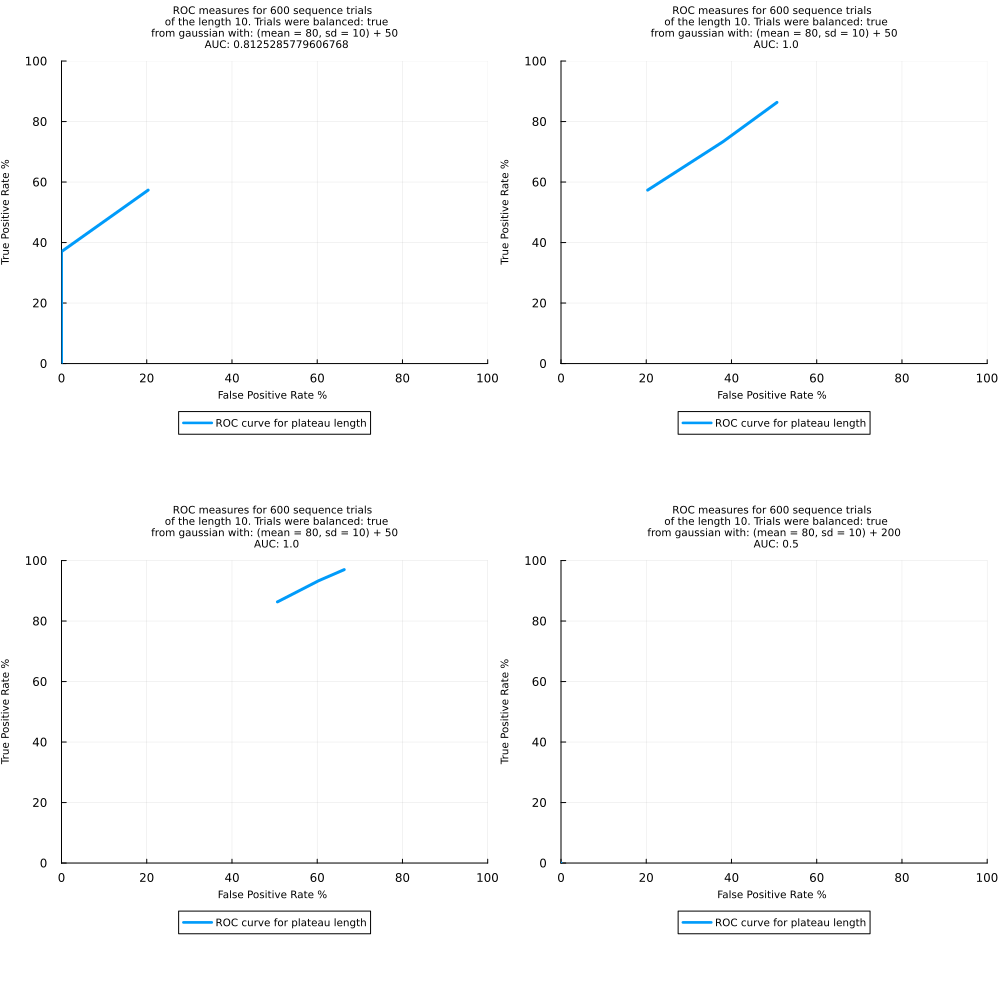

In [52]:
using ROCAnalysis
using Plots
distname = gaussian 

# (tau,fp,fn,tp,tn)
function example(performances, distribution; setup::NamedTuple, counter=0)
    performance = performances[2]
    distargs = performances[1]
    timing_mean = performances[3]
    if counter == 2
        FP_rate , TP_rate = roc(performance[82:181])
    elseif counter == 3 
        FP_rate , TP_rate = roc(performance[182:281])
    else
        FP_rate , TP_rate = roc(performance[1:81])
    end 

    AUC_score = auc(FP_rate, TP_rate)
    plot_title = "ROC measures for $(setup.trial_per_experiment) sequence trials \n of the length $(setup.sequence_length). Trials were balanced: $(setup.balanced)\n from $distribution with: $distargs + $timing_mean \n AUC: $AUC_score"
    plot(FP_rate , TP_rate; title=plot_title, label="ROC curve for plateau length", lw=3, titlefontsize=7)
    plot!(ylims=(0, 100))
    plot!(xlims=(0, 100))
    plot!(xlabelfontsize=7)
    plot!(ylabelfontsize=7)
    plot!(legend=:outerbottom, legendfontsize=7)
    ylabel!("True Positive Rate %")
    xlabel!("False Positive Rate % \n")
end


auc1 = example(performances[50], string(distname); setup=experiment_setup)
auc2 = example(performances[50], string(distname); setup=experiment_setup, counter=2)
auc3 = example(performances[50], string(distname); setup=experiment_setup, counter=3)
auc4 = example(performances[200], string(distname); setup=experiment_setup)

combined_plot = plot(auc1, auc2, auc3, auc4, layout=(2, 2), size=(1000, 1000))
